# Syntactic Analysis - Assignment


### Submitted By:
Mudassar Dildar Majgaonkar

# Problem Statement

The vanilla Viterbi algorithm has low accuracy because it cannot handle the unknown words (words that are not present in the tagged test set). For such unknown words the emission probability is zero and thats why the algorithm choses the first tag available and assigns it to the word. This is very crude method to aasign tags to unknown words.

In this assignment we will modify the Viterbi Algorithm to handle the unknown words so that the algorithm doesnt assign the tag randomly and uses some features of words like morphology, frequency or probability of occurrence to assign the correct tag to the unknown words encountered thereby increasing the accuracy of POS tagging.


# Data Understanding and Preparation

Before we dive into the actual algorithm implementation lets analyze and understand the nltk dataset we will be using for training and validating the algorithm.

For this assignment,we will use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

Using only 12 coarse classes (compared to the 46 fine classes such as NNP, VBD etc.) will make the Viterbi algorithm faster as well.

**We will use only these 12 classes for tagging the unknown words later on.**

In [1]:
#Basic Jupyter notebook and code settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import important libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [3]:
#Since its mentioned in the problem statement, we will be using only universal tags for this assignement.
# Read the Treebank tagged sentences with only universal tags
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

#Check the sample data
print(nltk_data[:1])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]]


As mentioned we will split the data in 95:5 ratio for training and validation

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, validation_set = train_test_split(nltk_data,test_size=0.05,random_state=1)

print("Length of train set: ",len(train_set))
print("Length of validation set: ",len(validation_set))

Length of train set:  3718
Length of validation set:  196


Now lets read the test sentences and store them in test_set which we will use later for testing


In [5]:
#Read and store the test data
fhandle = open('Test_sentences.txt')
raw_data = fhandle.read()

#Tokenize the read file
test_set = word_tokenize(raw_data)

#Store all the words in lower case format so that if easy to compare later
test_set = [w.lower() for w in test_set]

#Check the sample test set
test_set[:5]

['android', 'is', 'a', 'mobile', 'operating']

Now lets analyze the train and validation set a little in more detail and pre-process it.

In [6]:
# Get the list of tagged words from the train dataset
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Number of words in train dataset: ",len(train_tagged_words))

Number of words in train dataset:  95668


In [7]:
#Get the vocaubulary words and tags from the train set

#Vocabulary Words 
#Since the entries are in form of tuple(word,tag) we seperate the words and tags

#Preprocess and store the words in lowercase to eliminate duplicacy in set
words = [pair[0].lower() for pair in train_tagged_words]

#Check sample words
print("Sample words: {}\n".format(words[:5]))

#Vocabulary words
vocab_words = set(words)

#Check the length of actual unique vocabulary words
print("There are {} vocabulary words in train_set.\n".format(len(vocab_words)))

# Now check the tags in the train dataset
tags = set([pair[1] for pair in train_tagged_words])
print("There are {} tags in train_set and they are {}. \n".format(len(tags),tags))

Sample words: ['he', 'has', 'promised', 'stiffer', 'fines']

There are 11104 vocabulary words in train_set.

There are 12 tags in train_set and they are {'NUM', 'VERB', 'DET', 'ADV', '.', 'ADJ', 'ADP', 'CONJ', 'PRT', 'PRON', 'NOUN', 'X'}. 



As mentioned in the Problem Statement we could see the list of Universal tagset above.

Similarly lets verify the validation set details

In [8]:
# Get the list of tagged words from the train dataset
validation_tagged_words = [tup for sent in validation_set for tup in sent]
print("Number of words in validation dataset: ",len(validation_tagged_words))

#Get the vocaubulary words and tags from the train set

#Vocabulary Words 
#Since the entries are in form of tuple(word,tag) we seperate the words and tags

#Preprocess and store the words in lowercase to eliminate duplicacy in set
val_words = [pair[0].lower() for pair in validation_tagged_words]

#Check sample words
print("Sample words: {}\n".format(val_words[:5]))

#Vocabulary words
vocab_val_words = set(val_words)

#Check the length of actual unique vocabulary words
print("There are {} vocabulary words in validation_set.\n".format(len(vocab_val_words)))

# Now check the tags in the train dataset
val_tags = set([pair[1] for pair in validation_tagged_words])
print("There are {} tags in validation_set and they are {}. \n".format(len(val_tags),val_tags))

Number of words in validation dataset:  5008
Sample words: ['while', 'the', 'new', 'proposal', 'might']

There are 1780 vocabulary words in validation_set.

There are 12 tags in validation_set and they are {'NUM', 'VERB', 'DET', 'ADV', '.', 'ADJ', 'ADP', 'CONJ', 'PRT', 'PRON', 'NOUN', 'X'}. 



Now lets check the frequency of the tags in the original dataset.

In [9]:
#Check the tags in overall dataset
tagged_words_all = [tup for sent in nltk_data for tup in sent]
tags_all = [pair[1] for pair in tagged_words_all]
tag_counts_all = Counter(tags_all)

#Print the counts in sorted order
print(sorted(tag_counts_all.items(), key = lambda kv:(kv[1], kv[0]))) 

[('CONJ', 2265), ('PRON', 2737), ('ADV', 3171), ('PRT', 3219), ('NUM', 3546), ('ADJ', 6397), ('X', 6613), ('DET', 8725), ('ADP', 9857), ('.', 11715), ('VERB', 13564), ('NOUN', 28867)]


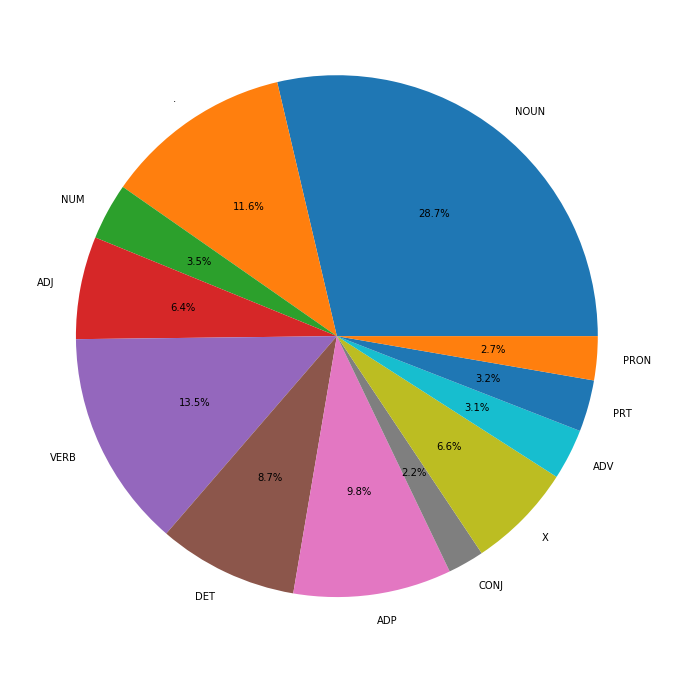

In [10]:
#Lets plot the count of tags and check it?
plt.figure(figsize=(12,12))
plt.pie(list(tag_counts_all.values()), labels=list(tag_counts_all.keys()), autopct='%1.1f%%');

As seen from the above plot it seems like NOUN's comprise of large amount in dataset approx 29%; followed by VERB's 14% and the '.' sentence punctuations with 12%.

So from above graph its clear that **NOUN** is most frequent tag in the dataset.

Now since we have checked the basic information about the dataset, lets dive into the pre-peparation steps for implementing the Viterbi Algorithm.

### POS Tagging Algorithm - 

We'll use the HMM algorithm to tag the words. 

Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 


In other words, to every word w, assign the tag t that **maximises the likelihood P(t/w).**

**Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).**


P(w/t) is basically the probability that given a tag (say NOUN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NOUNs which are equal to w, i.e. 
P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. 

In other words, the probability of a tag being NOUN will depend only on the previous tag t(n-1). 

So for e.g. if t(n-1) is a ADJ, then t(n) is likely to be an NOUN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. 

The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

For the sake of implementing Viterbi Algorithm we will compute the **Transition and Emission Probabilities**.

**Emission Probablility is nothing but the probability of of a word given tag i.e P(w|t)**

In [11]:
#Emission Probability: compute probabiliyword given tag
def emission_probability(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    emission_probability = count_w_given_tag/count_tag
    return (count_w_given_tag, count_tag, emission_probability)

In [12]:
#Verify if it works fine for few words
print("There are {} mentions of Andriod as Noun among {} Nouns. Emission probability:{} ".format(emission_probability('Andriod','NOUN')[0],emission_probability('Andriod','NOUN')[1],emission_probability('Andriod','NOUN')[2]))
print("There are {} mentions of news as Noun among {} Nouns. Emission probability:{} ".format(emission_probability('news','NOUN')[0],emission_probability('news','NOUN')[1],emission_probability('news','NOUN')[2]))
print("There are {} mentions of news as Verb among {} verbs. Emission probability:{} ".format(emission_probability('news','VERB')[0],emission_probability('news','VERB')[1],emission_probability('news','VERB')[2]))
print("There are {} mentions of a as DET among {} DETs. Emission probability:{} ".format(emission_probability('a','DET')[0],emission_probability('a','DET')[1],emission_probability('a','DET')[2]))

There are 0 mentions of Andriod as Noun among 27474 Nouns. Emission probability:0.0 
There are 22 mentions of news as Noun among 27474 Nouns. Emission probability:0.0008007570794205431 
There are 0 mentions of news as Verb among 12864 verbs. Emission probability:0.0 
There are 1786 mentions of a as DET among 8294 DETs. Emission probability:0.21533638775018085 


Emission probabilities seem to be working for with this initial testing. 

So the **emission_probability** function defined above takes 2 arguments: word and tag. It takes train_tagged_words by default argument, for finding the counts in the train set. It outputs the number of words tagged with given tag, number of tags in the train_set and the transition probabilities of the the word given tag. 

Now lets compute the Transition Probability.

**Transition probability is the probablity of current tag given previous tag. i.e: If t2 is current tag and t1 is previous tag then P(t2|t1)**

In [13]:
#Transition Probability: Compute probability of tag2(t2) given tag1 (t1)
def transition_probability(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    transition_prob = count_t2_t1/count_t1
    return (count_t2_t1, count_t1,transition_prob)

The **transition_probability** function defined above takes two arguments current tag(t2) and the previous tag(t1) along with by default train_tagged_words from train_set for training. The function outputs the count of t2 given t1, count of t1 and the transition probablities of t2 given t1.

**NOTE: For vanilla Viterbi Implementation the transition probability function uses just current and previous tags for probability calculation**

In [14]:
#Test on sample from train set
print("There are {} mentions of CONJ(t1) before VERB(t2) and {} mentions of Verb(t1). Transition probability:{} ".format(transition_probability(t2='VERB',t1='CONJ')[0],transition_probability(t2='VERB',t1='CONJ')[1],transition_probability(t2='VERB',t1='CONJ')[2]))     

There are 332 mentions of CONJ(t1) before VERB(t2) and 2148 mentions of Verb(t1). Transition probability:0.15456238361266295 


Seems the sample example for transition probability calculation above is working fine.
Now lets calculate the transition tag matrix.

In [15]:
#The lookup in the transition matrix heavily reduces the execution time rather than calculating it in Viterbi everytime
#Considering the tags combo. So we follow the same route.
#Create t x t transition matrix of tags
#Each column is t2, each row is t1
#Thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = transition_probability(t2, t1)[0]/transition_probability(t2, t1)[1]
        if (tags_matrix[i, j]==0):
            print(i,j)
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,NUM,VERB,DET,ADV,.,ADJ,ADP,CONJ,PRT,PRON,NOUN,X
NUM,0.184876,0.016672,0.003275,0.002977,0.118190,0.033343,0.033641,0.013397,0.027687,0.001191,0.350402,0.214350
VERB,0.022621,0.168688,0.135728,0.081468,0.035370,0.064599,0.090874,0.005442,0.031250,0.036070,0.111085,0.216807
DET,0.022305,0.038944,0.005305,0.012539,0.018085,0.204847,0.009163,0.000482,0.000241,0.003497,0.638896,0.045696
ADV,0.031635,0.346653,0.068931,0.078921,0.138528,0.128538,0.116550,0.006327,0.013986,0.015318,0.031635,0.022977
.,0.081764,0.088757,0.172136,0.052537,0.092254,0.043930,0.092433,0.058185,0.002062,0.065806,0.222342,0.027703
ADJ,0.021273,0.011544,0.004947,0.004782,0.064479,0.067282,0.076022,0.016985,0.010884,0.000660,0.700033,0.021108
ADP,0.061141,0.008352,0.323803,0.013813,0.040261,0.105793,0.017025,0.000857,0.001285,0.069172,0.324660,0.033837
CONJ,0.040503,0.154562,0.120577,0.054469,0.035382,0.121974,0.049814,0.000466,0.004190,0.059590,0.349628,0.008845
PRT,0.056026,0.400326,0.101629,0.010098,0.043648,0.085993,0.019544,0.002280,0.001954,0.018241,0.246254,0.014007
PRON,0.007285,0.480828,0.009586,0.035276,0.040261,0.072853,0.023006,0.004985,0.013037,0.006902,0.212040,0.093942


In [16]:
#Check if lookup is working fine
tags_df.min().min()
tags_df['NUM']['NUM']

0.00024113817

0.18487646

From above sample execution seems lookup is working fine.

Now since we have computed/defined both Emission and Transition Probablities lets define the **Viterbi Algorithm**.

The basic notion of Viterbi Algorithm is:
Given list of observations/words to be tagged rather than computing the probabilities of all the possible tag sequences assign the tags sequentially i.e: assign the most likely tag to each word using the previous tag.

Assign tag Tj to each word Wi such that it maximises the likelihood function

P(Tj | Wi) = P(Wi | Tj) * P(Tj | Tj-1)

    Where Tj is the current tag
          Wi is the current word
          Tj-1 is the previous tag
      
This likelihood function is called state probability and can be written as:
state_probability = transition_probability * emission_probability.

That's what we will do in the Viterbi Algorithm defined below.

In [17]:
# Define VANILLA Viterbi Algorithm
def Viterbi(words, method, train_bag = train_tagged_words):
    #Deine the list to capture the states/tags
    state = []
    
    #get the list of tags from train_set
    #Note Viterbi is Greedy Algorithm and it will assign the first entry as tag for the unknown words 
    #Since the state_probability will be ZERO as emission_probability will be ZERO
    T = list(set([pair[1] for pair in train_bag]))
    
    #In every run the list tag order changes so sort them for consistent o/p each time
    T.sort(reverse=True)
    print("Default tag list is: ", T)
    
    #List Unknown words from the i/p words just to check if tags are assigned properly later
    #Define list to append unknown words
    unknown_words=[]
    
    #Check for vocab words / known words
    known_words = list(set([pair[0] for pair in train_bag]))

    for w in words:
        if w not in known_words:
            unknown_words.append(w)
            
    #Check number of known words and Unknown words in the run
    print("Number of KNOWN words in this run are:",len(known_words))
    print("Number of Unknown words in this run are:",len(unknown_words))
    
    #Now for each word and tag calculate the transition and emission probabilities along with state probabilities
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            #Compute the Transition probabilities
            #The lookup in the transition matrix heavily reduces the execution time rather than calculating it here
            #So we follow the same route
            #if key == 0:
            #    transition_p = transition_probability('.', tag)[2]
            #else:
            #    transition_p = transition_probability(state[-1], tag)[2]
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]   
                
            #Compute Emission probabilities
            #Remember the emission_probability function returns 3 values and 3rd value is probability
            emission_p = float(emission_probability(words[key], tag)[2])
            
            #Calculate state probabilities
            state_probability = emission_p * transition_p 
            
            #Add this to probability matrix
            p.append(state_probability)
        
        #Calculate the max value of probability
        #For unknown words this values will be ZERO
        pmax = max(p)
        
        #Getting state/tag from tag list T for which probability is maximum
        #If its zero it will return the first tag in the list
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    #Final Word-Tag sequence
    tag_seq = list(zip(words, state))
    
    #For verification purpose later 
    #List out the unknown word and tag sequence as tagged by Viterbi Algorithm
    print("Tagged Unknown Words are: ")
    for i in range(len(tag_seq)):
        if tag_seq[i][0] in unknown_words:
            print(tag_seq[i])
    return tag_seq

Now since we have defined the Viterbi Algorithm lets test the VANILLA Viterbi algorithm on the test set.

For testing out the accuracy on validation and test set, we defined following methods below for common testing functions, which we can use later.

The **validation_testing** function tests the accuracy based on the algorithm passed and method used for handling unknown words.

Similarly **test_testing** function tests the accuracy of the algorithm and method used for handling unknown words.

Since we dont have tagset to compare the accuarcy for test set we will list out the use test cases which are wrongly or rightly tagged by the algorithm or method used.

We will be using 2 algorithms:

1)**Viterbi** - This is Vanilla Viterbi which has no logic to handle the unknown words.

2) **modified_Viterbi** - This algorithm, along with basic Viterbi Heuristic, has modified code to handle the unknown words.

We will use 4 methods to tests out the unknown words tagging:

1) **Laplace Smoothing**

2) **Most Probable Tag** which is based on most frequent tag in the dataset.

3) **Rule Based Tagging** which defines rules based on words morphology

4) **ngram_tagger** which uses ngram technique to handle the unknown words.

In [18]:
#Lets define 2 lists to capture the methods used for testing the unknown words and accuracy obtained
#We will append values and use them to evaluate later
method_list=[]
accuracy_list=[]

#This function takes 2 arguments
#algorithm: The algorithm used (Viterbi or modified_Viterbi)
#method: The method used to handle the unknwon words
def validation_testing(algorithm,method):
    # Running on entire test dataset takes more than 3-4hrs. 
    # So we will test our Viterbi algorithm on a few sample random sentences of test dataset
    random.seed(1234)

    #Choose random 5 sentences
    rndom = [random.randint(1,len(validation_set)) for x in range(5)]
    validation_run = [validation_set[i] for i in rndom]
    
    #In case you want to check on whole validation set uncomment this line and comment above 2 lines
    #validation_run = [validation_set[words] for words in validation_set]

    #List of Word-tags in those sentences for accuracy calculation later
    validation_run_base = [tup for sent in validation_run for tup in sent]

    #List of words
    validation_tagged_words = [tup[0] for sent in validation_run for tup in sent]


    #Tag the words extracted above using Viterbi Algorithm
    #Start time
    start = time.time()

    #Actual Tagging
    validation_seq = algorithm((validation_tagged_words),method)

    #End Time
    end = time.time()

    #Actual execution time
    difference = end-start

    print("Time taken for execution in validation run: ", difference)

    # Calculate the accuarcy
    #Check the word-tags in the validation_set against the word-tag as predicted by Viterbi
    check = [i for i, j in zip(validation_seq, validation_run_base) if i == j] 

    #Accuracy
    accuracy = round((len(check)/len(validation_seq))*100)
    print('Accuarcy of prediction in Validation set is {}% '.format(accuracy))
    
    #Append the method and accuracy to the list
    method_list.append(method)
    accuracy_list.append(accuracy)

In [19]:
#Check Viterbi for Vanilla method on Validation set
validation_testing(Viterbi,'Vanilla')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 10
Tagged Unknown Words are: 
('seven-yen', 'X')
('pledged', 'X')
('modernization', 'X')
('impeding', 'X')
('*T*-117', 'X')
('Jennison', 'X')
('7.79', 'X')
('7.52', 'X')
('7.60', 'X')
('suddenly', 'X')
Time taken for execution in validation run:  35.09143400192261
Accuarcy of prediction in Validation set is 87% 


The validation run shows the default accuarcy of 87% for the Viterbi.

Nonetheless our main concern is tagging the unknown words.
As seen from the above run we have 10 unknown words:
e.g: "pledged, Jennison,7.79",etc

All the unknown words are tagged as X (other: foreign words, typos, abbreviations) because that's the first entry in the input tag list.

All the unknown words whose emission probability is ZERO are by default assigned the first tag.

Out of these 3 words:

        pledged is a VERB wrongly tagged as X
        Jennison is a NOUN worngly tagged as X
        7.79 is a NUM and wrongly tagged as X.

Now lets check the same on the given test set.

In [20]:
#This function does testing on test set based on algorithm and method specified
def test_testing(algorithm,method):
    #Check the start and End Time for execution
    #Start time
    start = time.time()

    #Test the Vanilla Viterbi on test Set
    test_seq = algorithm(test_set,method)
    print("\n******* All the words tagged in Test Set are: ********\n")
    print(test_seq)

    #End time
    end = time.time()

    #Time taken
    difference = end-start
    print("Time taken for execution: ", difference)


In [21]:
#Test Viterbi algorithm on Vanilla method on test set
test_testing(Viterbi,'Vanilla')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 49
Tagged Unknown Words are: 
('android', 'X')
('google', 'X')
('android', 'X')
('os', 'X')
('worldwide', 'X')
('smartphones', 'X')
('2011', 'X')
('2013', 'X')
('google', 'X')
('twitter', 'X')
('2015', 'X')
('google', 'X')
('twitter', 'X')
('firehose', 'X')
('twitter', 'X')
('online', 'X')
('interact', 'X')
('messages', 'X')
('tweets', 'X')
('donald', 'X')
('trump', 'X')
('domineering', 'X')
('personality', 'X')
('2018', 'X')
('fifa', 'X')
('cup', 'X')
('21st', 'X')
('fifa', 'X')
('cup', 'X')
('tournament', 'X')
('contested', 'X')
('cup', 'X')
('eastern', 'X')
('europe', 'X')
('europe', 'X')
('trips', 'X')
('dallas', 'X')
('atlanta', 'X')
('i', 'X')
('denver', 'X')
('philadelphia', 'X')
('atlanta', 'X')
('arriving', 'X')
('san', 'X')
('francisco', 'X')
('nasa', 'X')
('invited', 'X')
('icesat-2', 

Now as seen from above execution there are 49 unknown words in this execution and all these words are tagged as X by the Vanilla Viterbi Implementation as its the first entry in the tag list which is wrong.

Consider the first few entries:
        
        "Android" is a name(NOUN) wrongly tagged as X
        "invited" is a VERB but wrongly tagged as X
        "2011" is a year(NUM) wrongly tagged as X
        
All the unknown words are wrongly tagged.

We will introduce couple of techniques to handle this issue and see if the accuracy of the VITERBI can be increased.

# Modified Viterbi for handling Unknown Words

In this section, we will introduce various methods to handle the unknown words which is one of the drawback of the Vaniall Viterbi Algorthm.

## Method 1: Laplace Smoothing

The issue with the Vanilla Viterbi is that the emission probability is ZERO if the word-tag pair is not found in the dataset.

One of the workaorund would be to smoothe out these ZERO values so that inspite of assigning ZERO values to emission probability and thereby the state probability (since emission_p * transition_p will be ZERO for emission_p = ZERO).

So we will use Laplace Smoothing like logic to forfeit this problem.

Here is the basic logic used:

If w is not in the training text then P(w|t) = 0. Despite of course being a very bad estimate of the true probability, zero-probabilities like this will also result in that all possible state-sequences for an observation sequence containing an unknown word will have probability 0 and therefore we cannot choose between them.

One way of solving this problem is using Laplace smoothing. 

This gives us:

P(w|T) = (count(w|T) +1 ) / (count(T) + |V |) 

where,

count(w|T) is count of word given tag
count(T) is count of tag
|V | is smoothing co-efficient i.e: the number of vocabulary words in the training text.

Based on these the viterbi Algorithm defined earlier is now modified as below.


In [22]:
# This function defines modified Viterbi Algorithm
#It takes additional i/p as method (method used for handling unknown words)
#and n which is the attribute used later for ngram Tagging.

def modified_Viterbi(words,method, n=2,train_bag = train_tagged_words):
    #Deine the list to capture the states/tags
    state = []
    
    #get the list of tags from train_set
    #Note Viterbi is Greedy Algorithm and it will assign the first entry as tag for the unknown words 
    #Since the state_probability will be ZERO as emission_probability will be ZERO
    T = list(set([pair[1] for pair in train_bag]))
    
    #In every run the list tag order changes so sort them for consistent o/p each time
    T.sort(reverse=True)
    print("Default tag list is: ", T)
    
    #List Unknown words from the i/p words just to check if tags are assigned properly later
    #Define list to append unknown words
    unknown_words=[]
    
    #Check for vocab words / known words
    known_words = list(set([pair[0] for pair in train_bag]))

    for w in words:
        if w not in known_words:
            unknown_words.append(w)
            
    #Check number of known words and Unknown words in the run
    print("Number of KNOWN words in this run are:",len(known_words))
    print("Number of Unknown words in this run are:",len(unknown_words))
    print('Method used for tagging Unknown Words is:', method)
    #Now for each word and tag calculate the transition and emission probabilities along with state probabilities
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            #Compute the Transition probabilities
            #The lookup in the transition matrix heavily reduces the execution time rather than calculating it here
            #So we follow the same route
            #if key == 0:
            #    transition_p = transition_probability('.', tag)[2]
            #else:
            #    transition_p = transition_probability(state[-1], tag)[2]
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]   
                
            #Compute Emission probabilities
            #Remember the emission_probability function returns 3 values and 3rd value is probability
            emission_p = float(emission_probability(words[key], tag)[2])
            
            #If emission_p is zero smoothe out the value using formula as defined above.
            if(method=='laplace_smoothing'):
                if(emission_p==0):
                    emission_p = float((emission_probability(words[key], tag)[0] + 1)/ + (emission_probability(words[key], tag)[1] + len(train_bag)))
            
            #Calculate state probabilities
            state_probability = emission_p * transition_p 
            
            #Add this to probability matrix
            p.append(state_probability)
        
        #Calculate the max value of probability
        #For unknown words this values will be ZERO
        pmax = max(p)
        if pmax ==0.0:
            #methods to handle unknown words
            #Rule Based tagger
            if(method=='rule_tagger'):
                state_max = rule_tagger(words[key])
            #ngram Tagger
            elif(method=='ngram_Tagger'):
                state_max = ngram_Tagger(words[key],n=n)
            #Frequency Based Tagger
            elif(method=='frequency_based_tagging'):
                state_max = frequency_based_tagging()
        else:
            #Getting state/tag from tag list T for which probability is maximum
            #If its zero it will return the first tag in the list
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    #Final Word-Tag sequence
    tag_seq = list(zip(words, state))
    
    #For verification purpose later 
    #List out the unknown word and tag sequence as tagged by Viterbi Algorithm
    print("Tagged Unknown Words are: ")
    for i in range(len(tag_seq)):
        if tag_seq[i][0] in unknown_words:
            print(tag_seq[i])
            
    return tag_seq

**Note:** This take time to execute since probabilities are re-calculated. Some patience please!!!!! :)

In [23]:
#Check the laplace_smoothing modification on modified Viterbi algorithm on Validation set
validation_testing(modified_Viterbi,'laplace_smoothing')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 10
Method used for tagging Unknown Words is: laplace_smoothing
Tagged Unknown Words are: 
('seven-yen', 'NOUN')
('pledged', '.')
('modernization', 'DET')
('impeding', 'VERB')
('*T*-117', 'DET')
('Jennison', '.')
('7.79', 'DET')
('7.52', 'DET')
('7.60', 'DET')
('suddenly', 'X')
Time taken for execution in validation run:  96.88636922836304
Accuarcy of prediction in Validation set is 87% 


As seen from above there isnt much improvement in the accuracy (87%) but if you observe closely not all unknown words are assigned default 'X' tag as it was for Vanilla Viterbi.

Infact few of the words are correctly tagged.

e.g: 
     
     impeding - VERB (earlier tagged as X)

     seven-yen -NOUN (currency earlier tagged as X)
     
So few words are correctly tagged and there is slight improvement over the default tagging.

Hence this method seems good. Lets check the test set.

In [24]:
#Check laplace smoothing on test set
test_testing(modified_Viterbi,'laplace_smoothing')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 49
Method used for tagging Unknown Words is: laplace_smoothing
Tagged Unknown Words are: 
('android', 'NOUN')
('google', 'DET')
('android', 'NOUN')
('os', 'NOUN')
('worldwide', '.')
('smartphones', 'DET')
('2011', 'DET')
('2013', 'DET')
('google', 'NOUN')
('twitter', 'NOUN')
('2015', 'DET')
('google', 'X')
('twitter', 'VERB')
('firehose', 'VERB')
('twitter', 'NOUN')
('online', 'NOUN')
('interact', 'NOUN')
('messages', 'DET')
('tweets', 'DET')
('donald', 'NOUN')
('trump', '.')
('domineering', 'NOUN')
('personality', '.')
('2018', 'NOUN')
('fifa', '.')
('cup', '.')
('21st', 'NOUN')
('fifa', '.')
('cup', '.')
('tournament', '.')
('contested', 'NOUN')
('cup', '.')
('eastern', 'DET')
('europe', 'NOUN')
('europe', 'DET')
('trips', '.')
('dallas', 'DET')
('atlanta', 'VERB')
('i', 'X')
('denver', 'DET')


Also as seen on the test set, most of the NOUN's are correctly tagged using Laplace smoothing as compared to the default Vanilla method where all were tagged as 'X'.

e.g:

    android - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)
    europe - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)
    donald - tagged as 'NOUN' (earlier tagged as 'X' by Vanilla)
    
 Despite these modifications most of the non-NOUN's (words which are not NOUN) are incorrectly tagged.
 
 Still its desirable over Vanilla Viterbi Heuristics where almost all the words were wrongly tagged.
 
 Although LAPLACE_SMOOTHING is not completely usuable but still useful over VANILLA VITERBI heuristics.
    

## Method 2 - Most Probable Tag

This method is based on the assumption that the unknown words would belong to the tag-category of the most frequently tagged words in the dataset.

This is a valid assumption since the most frequently occuring tags, are more prone to occur again and belong to the unknown words.

So in this method we will find the most frequently occurring tag in the dataset and then tag the unknown words with that tag.

In [25]:
#This function extracts the most frequently occuring tag in dataset
#And assigns the unknown word with that tag.
#This function takes the train dataset as i/p
def frequency_based_tagging(train_bag=train_tagged_words):
    #Extract tags
    tags = [tag for (word, tag) in train_bag]
    
    #Find most frequently occuring tag and return it to tag unknown word.
    predicted_tag = nltk.FreqDist(tags).max()
        
    return predicted_tag   
    

Now lets check this modified method on Validation and Test set

In [26]:
#Check the Frequency based method on Validation set
validation_testing(modified_Viterbi,'frequency_based_tagging')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 10
Method used for tagging Unknown Words is: frequency_based_tagging
Tagged Unknown Words are: 
('seven-yen', 'NOUN')
('pledged', 'NOUN')
('modernization', 'NOUN')
('impeding', 'NOUN')
('*T*-117', 'NOUN')
('Jennison', 'NOUN')
('7.79', 'NOUN')
('7.52', 'NOUN')
('7.60', 'NOUN')
('suddenly', 'NOUN')
Time taken for execution in validation run:  17.960902214050293
Accuarcy of prediction in Validation set is 88% 


As we can see that the accuracy is jumped up to **88%** which is imporvemnet over previous methods used.

Since **NOUN** is the most frequent tag in the dataset also observed in the pie-chart earlier this gets assigned to all the unknown words. This is similar to the Vanilla Viterbi but the only difference is instead of random assignement we are assigning the tags based on assumption that most frequently occurring tags are more likely to be tagged for unknown words.

There are few words thats are correctlt tagged as per this assumption:
    
        Jennison: tagged as NOUN (ealier tagged as 'X' by Vanilla and '.' by laplace)
        
        seven-yen: tagged as NOUN (earlier tagged as 'X' by Vanilla although laplace tagged it correctly)
        
        *T*-117: tagged as NOUN seems correct since this might be name of flight (wrongly tagged by both Vanilla and Laplace)

In [27]:
#testing the frequency based method on test set
test_testing(modified_Viterbi,'frequency_based_tagging')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 49
Method used for tagging Unknown Words is: frequency_based_tagging
Tagged Unknown Words are: 
('android', 'NOUN')
('google', 'NOUN')
('android', 'NOUN')
('os', 'NOUN')
('worldwide', 'NOUN')
('smartphones', 'NOUN')
('2011', 'NOUN')
('2013', 'NOUN')
('google', 'NOUN')
('twitter', 'NOUN')
('2015', 'NOUN')
('google', 'NOUN')
('twitter', 'NOUN')
('firehose', 'NOUN')
('twitter', 'NOUN')
('online', 'NOUN')
('interact', 'NOUN')
('messages', 'NOUN')
('tweets', 'NOUN')
('donald', 'NOUN')
('trump', 'NOUN')
('domineering', 'NOUN')
('personality', 'NOUN')
('2018', 'NOUN')
('fifa', 'NOUN')
('cup', 'NOUN')
('21st', 'NOUN')
('fifa', 'NOUN')
('cup', 'NOUN')
('tournament', 'NOUN')
('contested', 'NOUN')
('cup', 'NOUN')
('eastern', 'NOUN')
('europe', 'NOUN')
('europe', 'NOUN')
('trips', 'NOUN')
('dallas', 'NOUN')


As said earlier NOUN seems to be the most frequent tag in dataset and hence all the unknown words are assigned this tag. But seems valid for this test set since most of the unknown words here belong to this category.

e.g:

        Twitter - correctly tagged as NOUN (earlier tagged as 'X' by Vanilla)
        Google  - correctly tagged as NOUN (earlier tagged as 'X' by Vanilla)
        dallas  - correctly tagged as NOUN (earlier tagged as 'X' by Vanilla)
        
 These words were wrongly tagged earlier  by both the methods.
 Seems this method is also useful over Vanilla Viterbi for tagging unknown words.

## Method 3: Rule Based Tagging

This method is based on assumption that the words follow certain morphological rules and we will exploit those rules to tag the unknown words.

Rules such as:

1) If words contain digits tag them as NUM 

2) If words are 'the,an,a,.....' etc tag them as DET

3) If certain words end with 'able,sive,tion' tag them as ADJ (e.g: abor**able** , expen**sive** , modernisa**tion**)

4) If certain words end with 'ly' tag them as ADV (e.g: ear**ly**)

5) If certain words end with 'ing,ed'ould' or are words like 'am,is,are,.....etc' tag them as VERB (e.g: runn**ing**)

6) If certain words end with 'ness,s' or any other words tag it default to NOUN (e.g: cleanli**ness**, dog**s**)

The 6th observation above is also based on fact that NOUN is most frequently observed tag in the dataset and using this assumption definitely increased the accuracy as seen earlier in frequency based tagger over Vanilla Viterbi, so we tag the default words as NOUN if none of the rules are satisfied.

In [28]:
#Rule based taggers
def rule_tagger(words,train_bag=train_set):
    words = [words]
    #Define the rules
    rule_tagger = nltk.RegexpTagger(
            [(r'.*-?[0-9]+(.[0-9]+)?$', 'NUM'),                     # cardinal numbers
             (r'(The|the|A|a|An|an)$', 'DET'),                      # articles
             (r'.*able$|.*sive$|.*tion$', 'ADJ'),                   # adjectives 
             (r'.*ly$', 'ADV'),                                     # adverbs
             (r'.*ing$|.*ed$|.*ould$', 'VERB'),                     # verbs
             (r'(am|is|was|are|were|be|been|has|have|had)','VERB'), #verbs
             (r'.*ness$|.*s$|.*|.*\'s$|.*s$', 'NOUN')               # nouns formed from adjectives/plural nouns         
            ])

    #return the predicted tag and assign it to unknown word.
    predicted_tag = rule_tagger.tag(words)[0][1]
    return predicted_tag

In [29]:
#Test the Rule based tagger on Validation Set
validation_testing(modified_Viterbi,'rule_tagger')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 10
Method used for tagging Unknown Words is: rule_tagger
Tagged Unknown Words are: 
('seven-yen', 'NOUN')
('pledged', 'VERB')
('modernization', 'ADJ')
('impeding', 'VERB')
('*T*-117', 'NUM')
('Jennison', 'NOUN')
('7.79', 'NUM')
('7.52', 'NUM')
('7.60', 'NUM')
('suddenly', 'ADV')
Time taken for execution in validation run:  14.297714948654175
Accuarcy of prediction in Validation set is 92% 


The accuracy seems to have been jumped from 88% to 92% which is a big leap. So Rule based tagger becomes most accurate among all the methods discussed until now.

As we can see words like:
    
        7.79,7,52,7.60 are now accurately assigned NUM tag (earlier tagged as 'X' by Vanilla)
        
        modernization is correctly assigned ADJ (earlier tagged as 'X' by Vanilla)
        
        suddenly is correctly assigned ADV (earlier tagged as 'X' by Vanilla)

In [30]:
#Test rule based tagger on Test set
test_testing(modified_Viterbi,'rule_tagger')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 49
Method used for tagging Unknown Words is: rule_tagger
Tagged Unknown Words are: 
('android', 'NOUN')
('google', 'NOUN')
('android', 'NOUN')
('os', 'NOUN')
('worldwide', 'NOUN')
('smartphones', 'NOUN')
('2011', 'NUM')
('2013', 'NUM')
('google', 'NOUN')
('twitter', 'NOUN')
('2015', 'NUM')
('google', 'NOUN')
('twitter', 'NOUN')
('firehose', 'NOUN')
('twitter', 'NOUN')
('online', 'NOUN')
('interact', 'NOUN')
('messages', 'NOUN')
('tweets', 'NOUN')
('donald', 'NOUN')
('trump', 'NOUN')
('domineering', 'VERB')
('personality', 'NOUN')
('2018', 'NUM')
('fifa', 'NOUN')
('cup', 'NOUN')
('21st', 'NOUN')
('fifa', 'NOUN')
('cup', 'NOUN')
('tournament', 'NOUN')
('contested', 'VERB')
('cup', 'NOUN')
('eastern', 'NOUN')
('europe', 'NOUN')
('europe', 'NOUN')
('trips', 'NOUN')
('dallas', 'NOUN')
('atlanta', 'NOU

On the test set most of the tags are accurately assigned.

e.g:

        invited - tagged as VERB (earlier tagged as 'X' by Vanilla)
        arriving -  tagged as VERB (earlier tagged as 'X' by Vanilla)
        San Francisco  - tagged as NOUN (earlier tagged as 'X' by Vanilla)
        
Seems rule based method is working just perfectly for our use case.

Though this method seems to be useful but maintaining the "rules database" is somewhat not feasible.

There got to be some workaround this.

# Method 4 - N-Gram POS Tagger

Though Rule Based tagging as described above seemed to increase the accuracy of tagging, maintaining the "rules database" is somewhat not feasible.

How about instead on hand coding the rules, the tagger inturn takes into consideration words/tags position and sequence into consideration and tags the unknown words accordingly.

This is what is done in this method: ngram tagging.

In ngram tagging, we use backoff pipeline method and 3 different gram models for testing.

1) unigram method: For determining the part of speech tag, it only uses a context of single word. This is equivalent to the lexical based tagging where the word is looked up into the dataset and if matching words is found the tag assigned to word in the dataset is assigned to the unknown word.

2) bigram method: bigram uses 2 words rather than single word as used in unigram. It basically uses the previous word to derive the context. By looking at the previous words and its part-of-speech, tag for the current word can be guessed.

3) trigram method: Similar to bigram but it uses considers 3 words: current and 2 previous words and their Part-of-speech for guessing the POS tag for the current word.

Similary, ngram  a subsequence of n items. But for now we will only consider upto 3 items or trigrams only.

The basic idea of NgramTagger is :

     -> By looking at the previous words and P-O-S tags, part-of-speech tag for the current word can be guessed.
    
     -> Each tagger maintains a context dictionary (ContextTagger parent class is used to implement it).
    
     -> This dictionary is used to guess that tag based on the context.
     
     -> The context is some number of previous tagged words in the case of NgramTagger.
     
In this method we will start with Trigram tagger and fall back to Bigram in case the word is still not tagged.
If even bigram is not able to tag it we will fall back to unigram and even if unigram is not able to tag it we will fall back to rule base tagger as default as defined above since we have proven that it works well for our use cases.

By default we will use bigram since in our testing we found that there isnt much difference in accuracy for bigram and trigram taggers and bigram tagging has less time complexity as compared to trigram.

This can we easily modified based on i/p parameter n.

For now we will use n=2 i.e: Bigram model

In [31]:
#Define the ngram function
#i/p: word to be tagged, n-uni/bi/tri gram based on value passed
def ngram_Tagger(words,n=2, train_sents=train_set, train_bag=train_tagged_words): 
    #Use rule base tagger as default tagger
    defaultTag = rule_tagger(words)
    #print(defaultTag)

    t0 = nltk.DefaultTagger(defaultTag)
    
    if (n <= 0):
        return t0
    #Unigram tagger fall back to default
    elif (n == 1):
        t1 = nltk.UnigramTagger(train_sents, backoff=t0)
        predicted_tag = t1.tag(words)[0][1]
        return predicted_tag
    #Bigram Tagger fall back to Unigram
    elif (n == 2):
        t1 = nltk.UnigramTagger(train_sents, backoff=t0)
        t2 = nltk.BigramTagger(train_sents, backoff=t1)
        predicted_tag = t2.tag(words)[0][1]
        return predicted_tag
    #trigram fallback to bigram
    else:
        t1 = nltk.UnigramTagger(train_sents, backoff=t0)
        t2 = nltk.BigramTagger(train_sents, backoff=t1)
        t3 = nltk.TrigramTagger(train_sents, backoff=t2)
        predicted_tag = t3.tag(words)[0][1]
        return predicted_tag


**Note:** Since this method combines 3 methods execution takes time. Patience Please!!!!! :)

In [32]:
#test ngram tagger on validation set
validation_testing(modified_Viterbi,'ngram_Tagger')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 10
Method used for tagging Unknown Words is: ngram_Tagger
Tagged Unknown Words are: 
('seven-yen', 'NOUN')
('pledged', 'VERB')
('modernization', 'ADJ')
('impeding', 'VERB')
('*T*-117', 'X')
('Jennison', 'NOUN')
('7.79', 'NUM')
('7.52', 'NUM')
('7.60', 'NUM')
('suddenly', 'ADV')
Time taken for execution in validation run:  27.013694286346436
Accuarcy of prediction in Validation set is 93% 


As seen from the above run with combination of bigram-unigram-rule-based tagger we are getting tagging accuracy to be 93% which is highest among all the methods discussed above.

As seen from above result almost all the unknown words are sort of correctly tagged.
e.g:

    pledged - correctly tagged as VERB (earlier tagged as 'X' by Vanilla)
    Jennison - correctly tagged as NOUN (earlier tagged as 'X' by Vanilla)
    suddenly - correctly tagged as ADV (earlier tagged as 'X' by Vanilla)
    
 Now lets check the test set.

In [33]:
#test ngram on test set
test_testing(modified_Viterbi,'ngram_Tagger')

Default tag list is:  ['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']
Number of KNOWN words in this run are: 12097
Number of Unknown words in this run are: 49
Method used for tagging Unknown Words is: ngram_Tagger
Tagged Unknown Words are: 
('android', 'X')
('google', 'NOUN')
('android', 'X')
('os', 'NOUN')
('worldwide', 'NOUN')
('smartphones', 'NOUN')
('2011', 'X')
('2013', 'X')
('google', 'NOUN')
('twitter', 'NOUN')
('2015', 'X')
('google', 'NOUN')
('twitter', 'NOUN')
('firehose', 'NOUN')
('twitter', 'NOUN')
('online', 'NOUN')
('interact', 'NOUN')
('messages', 'NOUN')
('tweets', 'NOUN')
('donald', 'NOUN')
('trump', 'NOUN')
('domineering', 'VERB')
('personality', 'NOUN')
('2018', 'X')
('fifa', 'NOUN')
('cup', 'NOUN')
('21st', 'X')
('fifa', 'NOUN')
('cup', 'NOUN')
('tournament', 'NOUN')
('contested', 'VERB')
('cup', 'NOUN')
('eastern', 'NOUN')
('europe', 'NOUN')
('europe', 'NOUN')
('trips', 'NOUN')
('dallas', 'NOUN')
('atlanta', 'X')
('i', 'NOUN')
(

As seen from the above run most of the words are also correctly tagged in the test set.

e.g: 
    
    arriving - correctly tagged as VERB (earlier tagged as 'X' by Vanilla)
    contested - correctly tagged as VERB (earlier tagged as 'X' by Vanilla)
    dallas - correctly tagged as NOUN (earlier tagged as 'X' by Vanilla)
    
As you can see android is tagged as 'X' which seems to be good even in this context since although a NOUN it is more like a foriegn word/abbrevation here in this context.

So seems like this ngram approach works way better than all the other methods.

Also sort of ngram is amalgamation of all the methods discussed above. It take into considertaion of all pros of all the basic methods defined above and hence it works most accurately.

# Evaluation and Observation

Now lets evaluate all the methods dicussed above.

For the sake of story formation lets plot few graphs and check.

In [34]:
#Make a dataframe of all the methods and accuracies noted earlier
method_accuracy = pd.DataFrame(list(map(list, zip(method_list,accuracy_list))), columns = ['method','accuracy'])

In [35]:
#Check the details
method_accuracy

,method,accuracy
0,Vanilla,87
1,laplace_smoothing,87
2,frequency_based_tagging,88
3,rule_tagger,92
4,ngram_Tagger,93


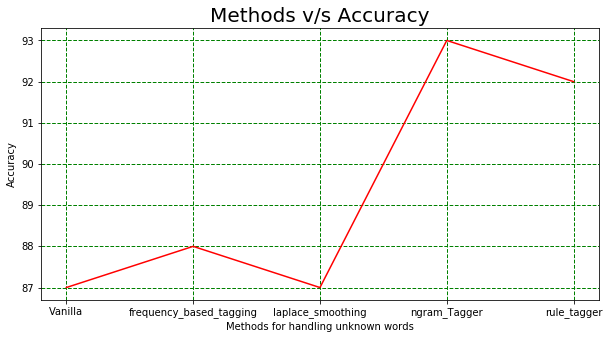

In [36]:
#Plot and check the method accuracies
plt.figure(figsize=(10,5))
plt.grid(color='g', linestyle='--', linewidth=1)
ax = sns.lineplot(x="method", y="accuracy", data=method_accuracy,color='red')
ax.axes.set_title("Methods v/s Accuracy",fontsize=20);
ax.set_xlabel("Methods for handling unknown words",fontsize=10);
ax.set_ylabel("Accuracy",fontsize=10);

As seen from the above table ngram tagger has high accuracy of 93%

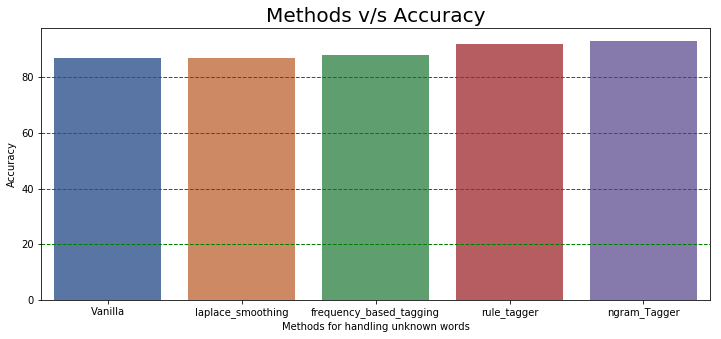

In [37]:
#Plot and check the methods accuracies
plt.figure(figsize=(12,5))
plt.grid(color='g', linestyle='--', linewidth=1)
ax=sns.barplot(x="method", y="accuracy", data=method_accuracy,palette='deep')
ax.axes.set_title("Methods v/s Accuracy",fontsize=20);
ax.set_xlabel("Methods for handling unknown words",fontsize=10);
ax.set_ylabel("Accuracy",fontsize=10);

From the aboe 2 plots its clear that Vanilla Viterbi and Laplace  have lowest accuracy of 87% while ngram tagger has the highest accuracy of 93%.

# Conclusion

For our use case ngram Tagger which is a combination of Rule Based Tagger, Unigram Tagger, Bigram Tagger and Trigram Tagger can be used for Tagging the unknown words in dataset and can be used in combination with Viterbi Heuristics to improve the efficiency of tagging the unknown words thereby improving the overall accuracy of the Viterbi Algorithm.